# MultiREx - Quickstart
#### Planetary transmission spectra generator
##### [GitHub Repository](https://github.com/D4san/MultiREx-public)
<a target="_blank" href="https://colab.research.google.com/github/D4san/MultiREx-public/blob/main/tutorials/multirex-quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## External dependencies

If you are workin in Google Colab use this to install dependencies. When installing `multirex`, `taurex3` is automatically installed.

In [64]:
import sys 
if 'google.colab' in sys.modules:
    !pip install -Uq multirex

In [65]:
import multirex as mrex
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# This is for developing purposes
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a single system

### Components

To start with, we need to provide to `MultiREx` the properties of the three components of any transmission model: A star, a planet and a planetary atmosphere. Here are the basic properties of each component:

- **Star**:
  - Effective temperature in Kelvins (attribute `temperature`).
  - Radius in solar radii (attribute `radius`).
  - Mass in solar masses (attribute `mass`).

- **Planet**:
  - Radius in Earth radii (attribute `radius`).
  - Mass in Earth masses (attribute `mass`).

- **Atmosphere**: 
  - Surface temperature in Kelvins (attribute `temperature`).
  - Surface pressure in Pascals (attribute `base_pressure`).
  - Pressure at the top of the atmosphere in Pascales (attribute `top_pressure`).
  - Composition (attribute `composition`). This is provided as a dictionary whose keys are the name of the components (e.g. 'CO2', 'CH4') and the value are the $log_{10}$ of the mixing ratio of the corresponding gas.  
  - Fill gass name (attribute `fill_gass`), i.e. the gass which fills the atmopshere (normally 'N2').

### Available gasses

If you want to see the list of available gasses in the package use:

In [66]:
mrex.Util.list_gases()

Available gases in the database:
['O2', 'O3', 'H2O', 'CO2', 'CH4']


`MultiREx` maintains a complete database of atmospheric gasses that can be retrieved using the command:

> **WARNING**: Be careful with this command: it will use as much as 4 GB of disk space.

In [67]:
mrex.Util.get_gases(path='/tmp')

The directory to the opacity database already exists in the specified path:  /tmp


Once downloaded, the list of available gasses are considerably larger:_

In [68]:
mrex.Util.list_gases()

Available gases in the database:
['O2', 'CO', 'HCN', 'O3', 'N2', 'SO2', 'C2H6', 'NH3', 'H2O', 'NO2', 'DMS', 'CO2', 'CH3Cl', 'CH4']


### Creating components of the system

Let's create a star:

In [69]:
star = mrex.Star(temperature=5777,radius=1,mass=1)

You may get the attributes of the star using:

In [70]:
star.mass, star.temperature

(1, 5777)

You may also modify the mass of the star:

In [71]:
star.set_mass(1.5)

Now create the planet:

In [72]:
planet = mrex.Planet(radius=1,mass=1)

And finally create the atmosphere:

In [73]:
atmosphere = mrex.Atmosphere(
    temperature=288, # in K
    base_pressure=1e5, # in Pa
    top_pressure=1, # in Pa
    fill_gas='N2', # the gas that fills the atmosphere
    composition=dict(
        CO2=-4, # This is the log10(mix-ratio)
        CH4=-6,
    )
)

Once created we can integrate the three components in a system:

In [74]:
planet.set_atmosphere(atmosphere)
system = mrex.System(star=star,planet=planet,sma=1)

ValueError: Atmosphere must be an Atmosphere object.

After ensembling the components you still have access to the properties independently:

In [ ]:
system.planet.radius

1

We can ensemble a system using a single command like:

In [ ]:
system = mrex.System(
    star=mrex.Star(
        temperature=5777,
        radius=1,
        mass=1
    ),
    planet=mrex.Planet(
        radius=1,
        mass=1,
        atmosphere=mrex.Atmosphere(
            temperature=290, # in K
            base_pressure=1e5, # in Pa
            top_pressure=1, # in Pa
            fill_gas='N2', # the gas that fills the atmosphere
            composition=dict(
                CO2=-4, # This is the log10(mix-ratio)
                CH4=-6,
            )
        )
    ),
    sma=1
)

### The transmission model

Once we have a system we can create the transmission model:

In [ ]:
system.make_tm()

The transmission model is a `Taurex` class that allows us to create transmission spectra as desired. It encapsulates all the attributes and methods used to described the atmosphere that are taken into account when calculating the transmission spectra. `MultiREx` essentially simplify the interaction with the wide range of options of `TauREx` for specifying those attributes.  

You may take a quick look to the attributes of the transmission model using:

In [ ]:
system.transmission.__dict__

{'_log_name': 'taurex.TransmissionModel',
 '_logger': <Logger taurex.TransmissionModel (ERROR)>,
 '_param_dict': {},
 '_derived_dict': {},
 'opacity_dict': {},
 'cia_dict': {},
 '_native_grid': None,
 '_derived_parameters': {'logg': ('logg',
   'log(g)',
   <bound method derivedparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x7fb4f93ca2f0>>,
   False),
  'avg_T': ('avg_T',
   '$\\bar{T}$',
   <bound method derivedparam.<locals>.wrapper of <taurex.data.profiles.temperature.isothermal.Isothermal object at 0x7fb4f93cbe20>>,
   False),
  'metallicity': ('metallicity',
   'Z',
   <bound method derivedparam.<locals>.wrapper of <taurex.data.profiles.chemistry.taurexchemistry.TaurexChemistry object at 0x7fb4f8888220>>,
   False),
  'mu': ('mu',
   '$\\mu$',
   <bound method derivedparam.<locals>.wrapper of <taurex.data.profiles.chemistry.taurexchemistry.TaurexChemistry object at 0x7fb4f8888220>>,
   True)},
 '_fitting_parameters': {'planet_mass': ('planet_mass',
   '$M_p$',
   

### Generating a transmission spectrum

In order to create and manipulate a transmission spectrum, we need first to genereta a wave number grid:

In [ ]:
wns = mrex.Physics.wavenumber_grid(wl_min=0.6,wl_max=10,resolution=1000)

The corresponding wavelength grid is:

In [ ]:
wls = np.sort(1e4/wns)
wls[:10],wls[-10:]

(array([0.6       , 0.60169212, 0.60338901, 0.60509068, 0.60679716,
        0.60850844, 0.61022456, 0.61194551, 0.61367132, 0.61540199]),
 array([ 9.74972472,  9.77722085,  9.80479454,  9.83244598,  9.86017541,
         9.88798304,  9.91586909,  9.94383379,  9.97187735, 10.        ]))

Let's generate the transmission spectrum:

In [ ]:
wns,spectrum = system.generate_spectrum(wns)
wls = 1e4/wns

The spectrum is an adimensional quantity given in terms of the fraction of the stellar area blocked by the planet and its atmosphere, in other words $(R_p/R_\star)^2$. It is conventionally measured in parts per million (ppm) and conventionally called *transit depth*. In our case, if the planet was air-less it will produce a spectrum with a depth of:

In [ ]:
from astropy.constants import R_sun, R_earth
1e6*(system.planet.radius*R_earth/(system.star.radius*R_sun))**2

<Quantity 84.05017877>

Once the spectrum has been calculated we can plot it:

Text(0, 0.5, 'Transit depth [ppm]')

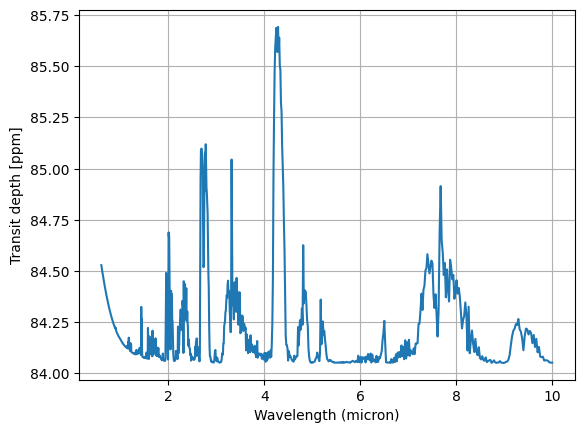

In [ ]:
plt.plot(wls,spectrum*1e6)
plt.grid()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Transit depth [ppm]')

You can also plot the spectrum using the *absortion height*, namely the apparent size of the atmosphere as seen at a given wavelength and which is given by:

$$
h = R_\star \left(\sqrt{S}  - \frac{R_p}{R_\star}\right)
$$

In [ ]:
effalts = (np.sqrt(spectrum)*system.star.radius*R_sun.value - system.planet.radius*R_earth.value)/1e3
effalts[:10]

array([0.07626681, 0.06778101, 0.11127472, 0.37537931, 0.50011134,
       0.52420784, 0.45433174, 1.1838071 , 1.08375566, 1.17605428])

This is precisely the function of the routine `mrex.Physics.spectrum2height`:

In [ ]:
effalts = mrex.Physics.spectrum2altitude(spectrum,system.planet.radius,system.star.radius)

Let's plot it:

Text(0, 0.5, 'Absortion height [km]')

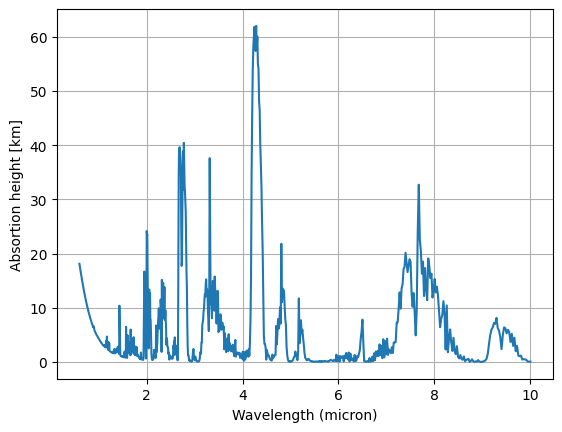

In [ ]:
plt.plot(wls,effalts)
plt.grid()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Absortion height [km]')

We have automated the spectrum plotting using the routine:

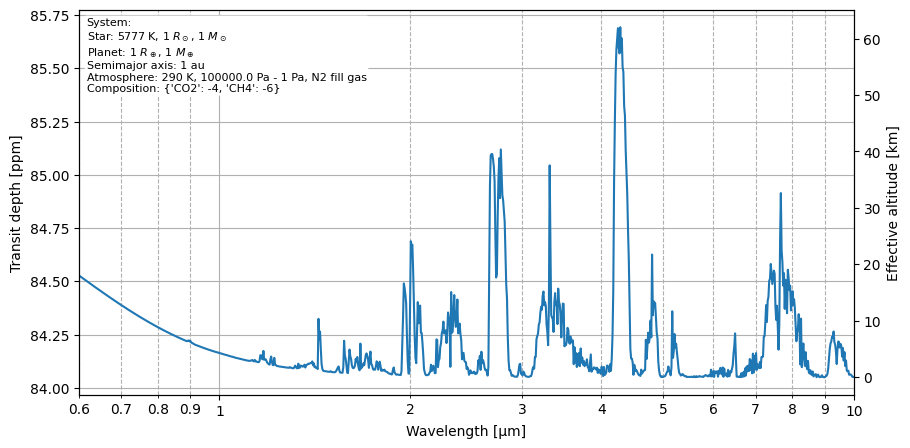

In [ ]:
fig, ax = system.plot_spectrum(wns,xscale='log')

### Studying spectral contributions

In order to understand a given spectrum you can also calculate all the individual contributions:

In [ ]:
wns, contributions = system.generate_contributions(wns)

Contributions are also calculated as transit depths. Contributions are given as a dictionary with two keys: *Absorption* and *Rayleigh* scattering. 

Text(0, 0.5, 'Transit depth [ppm]')

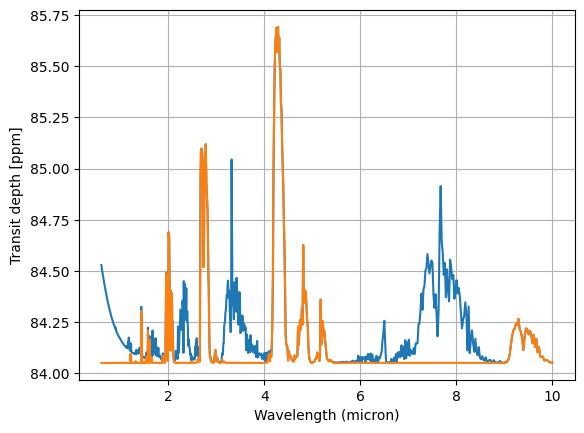

In [ ]:
plt.plot(wls,spectrum*1e6)
plt.plot(wls,contributions['Absorption']['CO2']*1e6)
plt.grid()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Transit depth [ppm]')

We have devised a special method to plot all contributions at once:

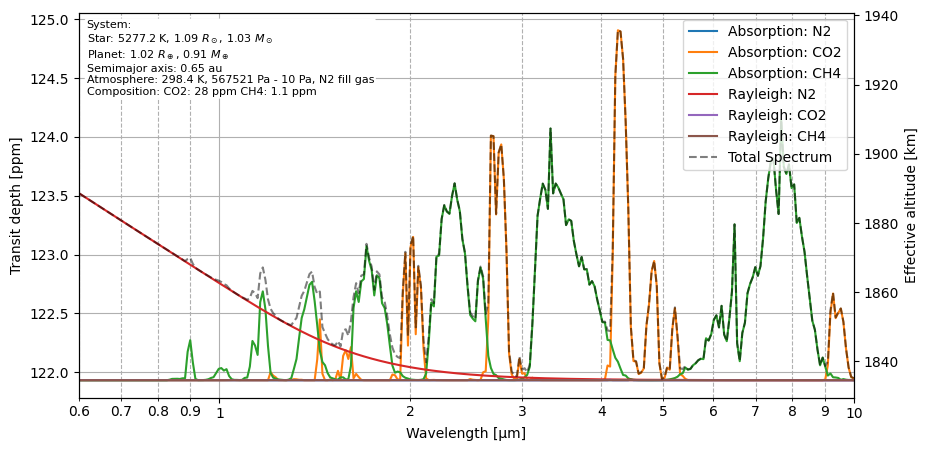

In [75]:
fig, ax = system.plot_contributions(wns,xscale='log')

In [76]:
fig.savefig('resources/constributions-transmission-spectrum.png')

### Observations

Once you have a theoretical transmission spectrum you may generate an observed spectrum. In the present version of `MultiREx` we use a very simplified model for error which is independent of wavelength and signal strength (transit depth). It simply adds a gaussian error to a spectra according to a constant noise which depends on a provided value of the signal-to-noise ratio (SNR).

In [36]:
observation = system.generate_observations(wns, snr=10)
observation

,noise,SNR,10.0,9.971877349033692,9.943833786417125,9.915869089732885,9.887983037189068,9.860175407617508,9.832445980472007,9.804794535826622,...,0.6154019907123947,0.6136713171735172,0.6119455107474266,0.6102245577465119,0.6085084445216544,0.6067971574621212,0.6050906829954558,0.6033890075873711,0.6016921177416427,0.6
0,1.641670e-07,10,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,...,0.000084,0.000085,0.000084,0.000085,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084


Observations are returned as a `pandas` dataframe which is more convenient for manipulation of large sets of spectra. You may obtain wavelengths and transit depths from a dataframe using:

In [37]:
noise, wls, spectra = mrex.Physics.df2spectra(observation)

Now you may plot the resulting observed spectrum:

Text(0, 0.5, 'Transit depth [ppm]')

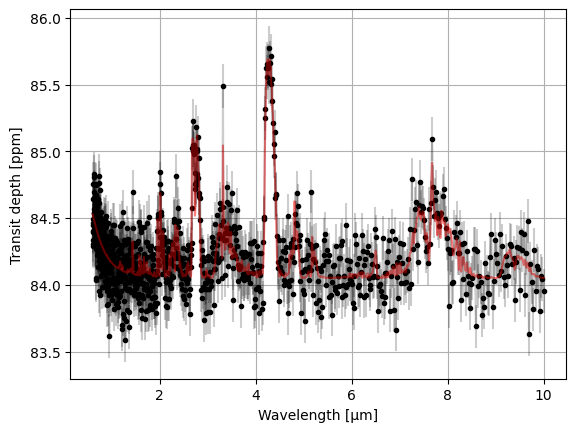

In [38]:
plt.plot(wls,spectra[0]*1e6,'k.')
plt.errorbar(wls,spectra[0]*1e6,yerr=noise[0]*1e6,color='k',alpha=0.2)
plt.plot(wls,spectrum*1e6,color='r',alpha=0.5)
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Transit depth [ppm]')

### Random systems

The superpower of MultiREx is its ability to generate random realizations of a system of star, planet and atmosphere. 

Let's assume for instance that all key parameters of the system components (stellar radius, planetary mass, atmospheric surface pressure, etc.) are physically and statistically independent. If we instantiate a system setting those parameters with a tuple `(min,max)` the properties of the system will be choosen as a uniformly-deviated random value in the interval `[min,max]`. See for instance:

In [39]:
system=mrex.System(
    star=mrex.Star(
        temperature=(4000,6000),
        radius=(0.5,1.5),
        mass=(0.8,1.2),
    ),
    planet=mrex.Planet(
        radius=(0.5,1.5),
        mass=(0.8,1.2),
        atmosphere=mrex.Atmosphere(
            temperature=(290,310), # in K
            base_pressure=(1e5,10e5), # in Pa
            top_pressure=(1,10), # in Pa
            fill_gas="N2", # the gas that fills the atmosphere
            composition=dict(
                CO2=(-5,-4), # This is the log10(mix-ratio)
                CH4=(-6,-5),
            )
        )
    ),
    sma=(0.5,1)
)

We can check the value of the key properties:

In [40]:
print(system.star.mass, 
      system.planet.atmosphere.temperature, 
      system.planet.atmosphere.base_pressure,
      system.planet.atmosphere.composition,
      system.sma)

1.0466508254871199 297.9131942101834 924699.9001657059 {'CO2': -4.251640304035881, 'CH4': -5.93401908906027} 0.6978298552545854


You may notice that the values are completely random. If you reshuffle the system:

In [41]:
system.reshuffle()

The values of the key parameters are entirely different:

In [42]:
print(system.star.mass, 
      system.planet.atmosphere.temperature, 
      system.planet.atmosphere.base_pressure,
      system.planet.atmosphere.composition,
      system.sma)

1.0229983632333557 299.78220774909533 555926.5991675559 {'CO2': -4.931827148635544, 'CH4': -5.391350825718696} 0.797359702638174


Having a realization of the system with different parameters is like living in a multiverse where everything is the same except for the particular value of the parameters of this system.

### Synthesizing spectra in the multiverse

Our last step is to generate a full set of synthetic theoretical and observed spectra for single realizations of the set of key parameters. 

In [43]:
system.make_tm()
wns = mrex.Physics.wavenumber_grid(wl_min=0.6,wl_max=10,resolution=300)

n_universes = 100
n_observations = 10
data = system.explore_multiverse(wns,snr=10,
                                 n_universes=n_universes,
                                 n_observations=n_observations,
                                 path='/tmp/')

spectra, observations = data.values()

Exploring universes: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
/home/jzuluaga/MultiREx-public/multirex/spectra.py:1346: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_spectra_df = pd.concat([all_header_df, all_spectra_df], axis=1)


Generating observations for 100 spectra...


Let's analyse the output of this code:

- `data`: A dictionary containing both, spectra and observations.

- `spectra`: A dataframe containing the theoretical spectra corresponding to each realization of the system key parameters. The number of rows of this dataframe is equal to the `n_universes` parameter. 

- `observations`: A dataframe cointaining the observed spectra made `n_observations` times in each parallel universe. The number of rows of this dataframe is equal to `n_universes*n_observations`. 

If you want to compare 3 observed spectra, made at the universe number `n` we use:

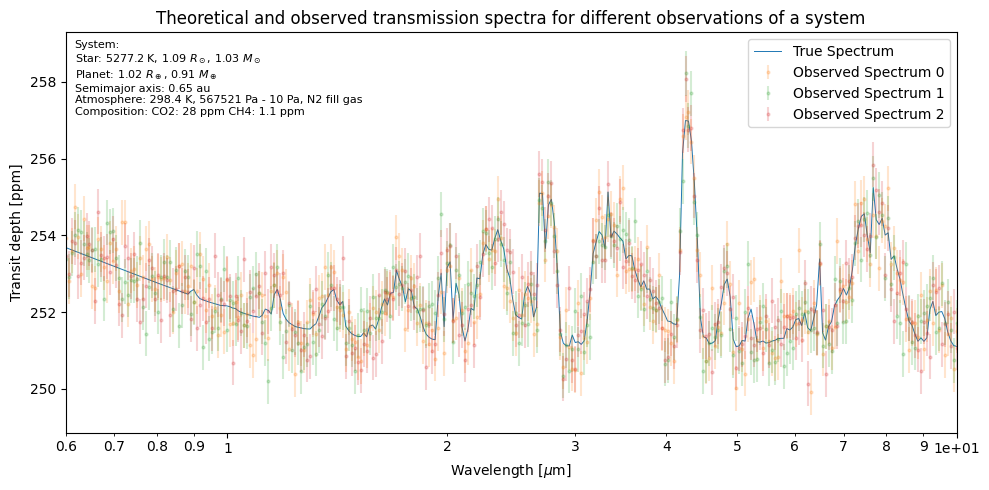

In [49]:
n = 5
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(1e4/wns,spectra.data.iloc[n]*1e6,label="True Spectrum",linewidth=0.7)
for i in range(3):
    ax.errorbar(x=1e4/wns,
                 y=observations.data.iloc[n*n_observations+i]*1e6,
                 yerr=observations.params["noise"][n*n_observations+i]*1e6,
                label=f"Observed Spectrum {i}",fmt="o",markersize=2,alpha=0.2)
    
ax.set_xscale("log")
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_ylabel(r"Transit depth [ppm]")
ax.set_title("Theoretical and observed transmission spectra for different observations of a system")
ax.legend()
ax.margins(x=0)

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: '{:.1g}'.format(y))
ax.xaxis.set_major_formatter(formatter)
formatter = FuncFormatter(lambda y, _: '{:.1g}'.format(y))
ax.xaxis.set_minor_formatter(formatter)

text = ax.text(0.01,0.98,system.__str__(),fontsize=8,verticalalignment='top',transform=ax.transAxes)
text.set_bbox(dict(facecolor='w',alpha=1,edgecolor='w',boxstyle='round,pad=0.1'))

fig.tight_layout()
fig.savefig("resources/synthetic-transmission-spectra.png")

Since in the last command you provided a value for the `path` variable, a `parquet` version of the dataframes are stored on disk in the `path` directory. 

> **WARNING**: Be careful when using this options since this files can be extremely large. 

<hr/>

This is the end